In [1]:
library(stringr)

# Ischemic time

GTEx samples have varying ischemic time (brain vs skin) which affects both sample and RNA integrity. It would be useful to see ischemic vs cell type estimate correlations/confidences.

In [159]:
fs = list.files(path = "../tables/Cibersort_out/", pattern = "mouse.csv", all.files = FALSE, full.names = TRUE)
fs = fs[! fs %in% '../tables/Cibersort_out//CIBERSORT.Output_Job93_lung_mouse.csv']

In [160]:
CalculateAverageDFromtheMean <- function(f){
    
    df = read.csv(f)
    rownames(df) = df[,1]
    df[,1] <- NULL
    df = df[, seq(1, (ncol(df) - 3))]
    L = ncol(df)
    N = nrow(df)
    mean = 1.0 / L


    for(subject in seq(1, N)){
        for(ct in seq(1, L)){
            ct_mean = mean(df[, ct])
            df[subject, paste("SDM", ct, sep = "_")] = (((df[subject, ct] - ct_mean)^2) / (ct_mean^2)) #* (N * (L*(N - 1))) #average distance from the mean
        }    
    }
    df.sdm = df[, grep("SDM", colnames(df))]
    
    return(df.sdm)
    
    
}

In [161]:
df.sdm = CalculateAverageDFromtheMean(fs[1])

var = list()
for(f in fs[1:length(fs)]){
    
    tiss = str_split_fixed(f, "_", 5)[, 4]
    df.sdm = CalculateAverageDFromtheMean(f)
    var[[tiss]] <- log(rowMeans(df.sdm) , 2)
    
}



In [5]:
gtex.meta = read.csv("/publicdata/gtex_v7/GTEx_v7_Annotations_SampleAttributesDS_V2.txt", sep = "\t")

In [221]:
figure_width  =  8.5
figure_height = 11
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss[, 2], tiss[, 1], method = "spearman"):
“Cannot compute exact p-value with ties”Warning message in cor.test.default(tiss

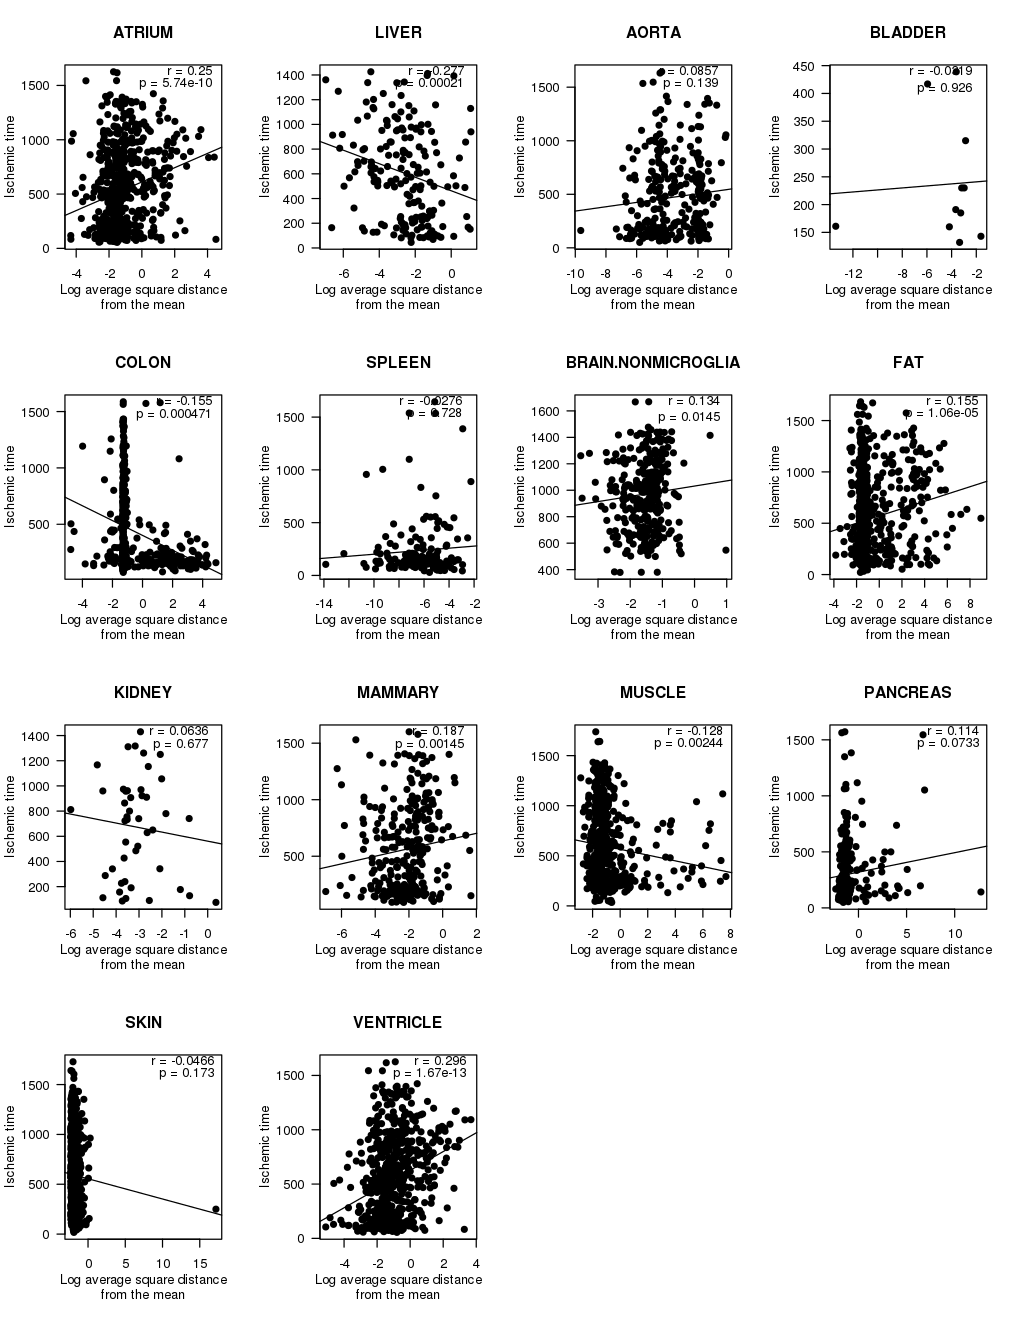

In [236]:
# pdf("review_ischemic.time.pdf", height = 11, width = 8.5)
par(mfrow = c(4, 4))
for( i in seq(1, length(var))){
        
    tiss = as.data.frame(var[[i]])
    nameTiss = names(var[i])
    tiss$SMTSISCH = gtex.meta[match(rownames(tiss), gtex.meta$SAMPID), "SMTSISCH"]

    tiss = tiss[ ! is.na(tiss$SMTSISCH), ]
    plot(tiss[,1], tiss[,2], pch = 19, las = 1, xlab = "Log average square distance\nfrom the mean", ylab = "Ischemic time", main = toupper(nameTiss))
    abline(lm(tiss[,2] ~ tiss[,1]))

    text(max(tiss[,1]) + (max(tiss[,1]) *.05), max(tiss[,2]), pos = 2, paste("r = ", signif(cor.test(tiss[,2], tiss[,1], method = "spearman")$estimate[[1]], 3), sep = ""))
    text(max(tiss[,1]) + (max(tiss[,1]) *.05), max(tiss[,2]) - (max(tiss[,2]) * .07) , pos = 2, paste("p = ", signif(cor.test(tiss[,2], tiss[,1], method = "spearman")$p.value, 3), sep = ""))
    
}
# dev.off()

# CIBERSORT P-value

In [246]:
for(i in seq(1, length(fs))) {
    
    df = read.csv(fs[i])
    df$fdr <- p.adjust(df$P.value)
    print(nrow(df[df$fdr < 0.05, ]) / nrow(df))
    
}



[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1
[1] 1


# eQTL effect size and cell proportion

1. Get cell-type-associated eQTLs
2. Look at distribution of Beta, SE, and P
3. Are they different (Mann Whitney U)
4. Ask if they are assocaited with more abundant cell types

In [767]:
liver_cells  = c("endothelial", "hepatocyte", "kupffer_cell", "nk_cell")
liver2_cells = c("endothelial_venous", "gdt", "hepatocyte0", "hepatocyte3", "hepatocyte4", "macrophage", "nkt_cell", "endothelial_periportal")
skin_cells   = c("epidermal", "keratinocyte_stem_cell", "leucocyte", "epidermal_stem_cell")

liver2_cells = data.frame(celltypes = c('central_venous_sinusoidal_endothelial_cells', 'gdT_cell', 'Hepatocytes0', 'Hepatocytes3', 'Hepatocytes4', 'inflammatory_macrophages', 'NK.NKT_cell', 'Periportal_sinusoidal_endothelial_cells'),
                         name      = c("endothelial_venous"                         , "gdt"     , "hepatocyte0" , "hepatocyte3" , "hepatocyte4" , "macrophage"              , "nkt_cell"   , "endothelial_periportal"                 ),
                         color     = c("#00c2c0"                                    , "#fa9c00" , "#b53bc7"     ,  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"                 , "#ff8e77"    , "#0075da"                                ))

liver_cells = data.frame(celltypes = c("B_cell", 'endothelial_cell_of_hepatic_sinusoid', 'hepatocyte', 'Kupffer_cell', 'natural_killer_cell' ),
                        name      =  c("B_cell", "endothelial"                         , "hepatocyte", "kupffer_cell", "nk_cell"              ),
                        color     =  c("#f7b98f", "#00c2c0"                             , "#b53bc7"   , "#f0d710"     , "#ff8e77"             ))

liver3_cells = data.frame(celltypes = c('merged_hepatocyte', 'merged_endothelial', 'merged_macrophage', 'merged_b_cell', 'merged_nk_nkt_cell', 'merged_cholangiocyte', 'merged_heptatic_stellate_cell'),
                         name      = c("merged_hepatocyte" , "merged_endothelial", "merged_macrophage" , "merged_b_cell", "merged_nk_nkt_cell", "merged_cholangiocyte", "merged_heptatic_stellate_cell"),
                         color     = c("#00c2c0"           , "#fa9c00" , "#b53bc7",  "#f1a8f2"    , "#ff4bcc"     , "#cdad02"                 , "#ff8e77"    ))



skin_cells = data.frame(celltypes = c("basal_cell_of_epidermis", "epidermal_cell", "keratinocyte_stem_cell", "leukocyte", "stem_cell_of_epidermis" ),
                       name      =  c("basal_cell_of_epidermis", "epidermal"     , "keratinocyte_stem_cell", "leukocyte", "epidermal_stem_cell"    ),
                       color     =  c("#f7b98f"                  , "#38ace2"       , "#a084bd"               , "#f067a1"  , "#e38725"                ))
         
cell2col = list(liver_cells = liver_cells, liver2_cells = liver2_cells, skin_cells = skin_cells)

In [691]:
ciber = read.csv("~/gtex_deconvolution/tables/Cibersort_out/CIBERSORT.Output_Job78_liver_mouse.csv")
ciber.skin = read.csv("~/gtex_deconvolution/tables/Cibersort_out/CIBERSORT.Output_Job97_skin_mouse.csv")

In [631]:
mouse_liver.eqtl = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/liver_cells/analysis/egenes.liver_cells.txt", header = T)
mouse_liver.cts  = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/liver_cells/analysis/lmm_compare.liver_cells.txt", header = T)

In [487]:
human_collapsed_liver.eqtl = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/liver3_cells/analysis/egenes.liver3_cells.txt", header = T)
human_collapsed_liver.cts  = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/liver3_cells/analysis/lmm_compare.liver3_cells.txt", header = T)

In [615]:
human_high_liver.eqtl = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/liver2_cells/analysis/egenes.liver2_cells.txt", header = T)
human_high_liver.cts  = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/liver2_cells/analysis/lmm_compare.liver2_cells.txt", header = T)

In [620]:
mouse_skin.eqtl = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells/analysis/egenes.skin_cells.txt", header = T)
mouse_skin.cts  = read.table("/frazer01/projects/GTEx_v7/analysis/eqtls_deconvolution/qtls/skin_cells/analysis/lmm_compare.skin_cells.txt", header = T)

In [862]:
PlotDensity <- function(cts.df, eqtl.df, name2use, colors2use, minX, maxX, minY, maxY){

    plot(1, type="n", xlab=name2use, ylab="Density", xlim=c(minX, maxX), ylim=c(minY, maxY), main = name2use, las = 1)

    for ( i in grep("^gt.*.pval$", colnames(cts.df))){

        cell = colnames(cts.df)[i]
        eqtl = cts.df[cts.df[,i] < 0.05, "id"]

        col2use = colors2use[colors2use$name == str_split_fixed(str_split_fixed(cell, "gt.", 2), ".pval", 2)[2,1], "color"]
        
        if(name2use == "fdr"){
            lines(density(-log(eqtl.df[eqtl.df$id %in% eqtl, name2use], 10)), col = col2use, lwd = 2, xlab = "-log(FDR)")            
        } else {lines(density(abs(eqtl.df[eqtl.df$id %in% eqtl, name2use])), col = col2use, lwd = 2)}
        
        

    }

#     legend(maxX / 3.2, maxY, legend=colors2use$name,
#            col=colors2use$color, lty=rep(1, length(colors2use$name)), cex=0.5, box.lty=0, bg="transparent")
}

In [770]:
CiberBarFrazer <- function(ciber, colors, main0, legy){
    
    par(mar = c(2, 4, 2, 0.5))
    
    rownames(ciber) <- ciber$Input.Sample
    ciber$Input.Sample <- NULL
    ciber = ciber[, seq(1, (ncol(ciber) - 3))]
    nsamples = nrow(ciber)
    ciber = as.data.frame(t(ciber) * 100)
    
    ciber$color = colors[ match(colors$celltypes, rownames(ciber)),  "color"]
    
    barplot(as.matrix(ciber[, seq(1, (ncol(ciber) - 1))]), las = 2, col = ciber$color, border=NA, names.arg = rep("", ncol(ciber) - 1), 
           ylab = "Fraction clusters", main = main0, space=0)

    text(nsamples * .01, legy + 3, paste("n = ", nsamples, sep = ""), pos = 4)

    legend(nsamples * .01, legy, gsub("_", " ", colors$celltypes), bty = "n",
           pch = rep(22, nrow(colors)),
           pt.cex = rep(1.5, nrow(colors)),
           pt.bg = colors$color )
    

}

In [807]:
CiberAvgCell <- function(ciber, colors){

    rownames(ciber) <- ciber$Input.Sample
    ciber$Input.Sample <- NULL
    ciber = ciber[, seq(1, (ncol(ciber) - 3))]
    ciber = as.data.frame(colMeans(ciber)) * 100
    ciber$color = colors[ match(colors$celltypes, rownames(ciber)),  "color"]
    
    barplot(ciber[,1], las = 2, names.arg = rownames(ciber), col = ciber$color)

    
}

In [859]:
CalculatePval <- function(cts.df, eqtl.df, name2use){
    
    dists = data.frame(value = NA, cellt = NA)


    for ( i in grep("^gt.*.pval$", colnames(cts.df))){

        cell = colnames(cts.df)[i]
        eqtl = cts.df[cts.df[,i] < 0.05, "id"]

        dists.temp = data.frame( value = eqtl.df[eqtl.df$id %in% eqtl, name2use], cellt = cell)
        dists = rbind(dists, dists.temp)

    }
    
    return(pairwise.wilcox.test(dists$value, dists$cellt, p.adjust.method = "none"))
    
}

In [860]:
dists = CalculatePval(mouse_liver.cts, mouse_liver.eqtl, "beta")
dists
dists = CalculatePval(mouse_liver.cts, mouse_liver.eqtl, "se")
dists
dists = CalculatePval(mouse_liver.cts, mouse_liver.eqtl, "fdr")
dists
dists = CalculatePval(mouse_skin.cts, mouse_skin.eqtl, "beta")
dists
dists = CalculatePval(mouse_skin.cts, mouse_skin.eqtl, "se")
dists
dists = CalculatePval(mouse_skin.cts, mouse_skin.eqtl, "fdr")
dists


	Pairwise comparisons using Wilcoxon rank sum test 

data:  dists$value and dists$cellt 

                     gt.endothelial.pval gt.hepatocyte.pval
gt.hepatocyte.pval   0.96                -                 
gt.kupffer_cell.pval 0.95                0.90              
gt.nk_cell.pval      0.21                0.18              
                     gt.kupffer_cell.pval
gt.hepatocyte.pval   -                   
gt.kupffer_cell.pval -                   
gt.nk_cell.pval      0.25                

P value adjustment method: none 


	Pairwise comparisons using Wilcoxon rank sum test 

data:  dists$value and dists$cellt 

                     gt.endothelial.pval gt.hepatocyte.pval
gt.hepatocyte.pval   0.28                -                 
gt.kupffer_cell.pval 0.40                0.89              
gt.nk_cell.pval      0.61                0.57              
                     gt.kupffer_cell.pval
gt.hepatocyte.pval   -                   
gt.kupffer_cell.pval -                   
gt.nk_cell.pval      0.73                

P value adjustment method: none 


	Pairwise comparisons using Wilcoxon rank sum test 

data:  dists$value and dists$cellt 

                     gt.endothelial.pval gt.hepatocyte.pval
gt.hepatocyte.pval   0.49                -                 
gt.kupffer_cell.pval 0.57                0.95              
gt.nk_cell.pval      0.76                0.30              
                     gt.kupffer_cell.pval
gt.hepatocyte.pval   -                   
gt.kupffer_cell.pval -                   
gt.nk_cell.pval      0.36                

P value adjustment method: none 


	Pairwise comparisons using Wilcoxon rank sum test 

data:  dists$value and dists$cellt 

                               gt.epidermal.pval gt.epidermal_stem_cell.pval
gt.epidermal_stem_cell.pval    0.65              -                          
gt.keratinocyte_stem_cell.pval 0.97              0.64                       
gt.leucocyte.pval              0.34              0.20                       
                               gt.keratinocyte_stem_cell.pval
gt.epidermal_stem_cell.pval    -                             
gt.keratinocyte_stem_cell.pval -                             
gt.leucocyte.pval              0.37                          

P value adjustment method: none 


	Pairwise comparisons using Wilcoxon rank sum test 

data:  dists$value and dists$cellt 

                               gt.epidermal.pval gt.epidermal_stem_cell.pval
gt.epidermal_stem_cell.pval    0.45              -                          
gt.keratinocyte_stem_cell.pval 0.71              0.69                       
gt.leucocyte.pval              0.37              0.12                       
                               gt.keratinocyte_stem_cell.pval
gt.epidermal_stem_cell.pval    -                             
gt.keratinocyte_stem_cell.pval -                             
gt.leucocyte.pval              0.23                          

P value adjustment method: none 


	Pairwise comparisons using Wilcoxon rank sum test 

data:  dists$value and dists$cellt 

                               gt.epidermal.pval gt.epidermal_stem_cell.pval
gt.epidermal_stem_cell.pval    0.06133           -                          
gt.keratinocyte_stem_cell.pval 0.01765           0.74284                    
gt.leucocyte.pval              0.29994           0.00458                    
                               gt.keratinocyte_stem_cell.pval
gt.epidermal_stem_cell.pval    -                             
gt.keratinocyte_stem_cell.pval -                             
gt.leucocyte.pval              0.00069                       

P value adjustment method: none 

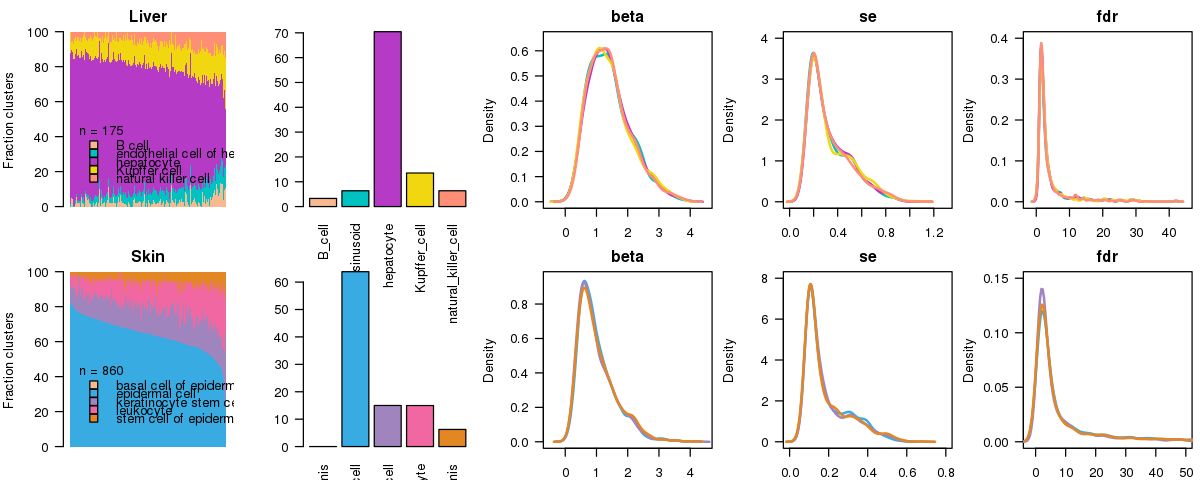

In [875]:
# pdf("~/gtex_deconvolution/Reviews/review_eqtl_stats.pdf", height = 4, width = 10)

figure_width  = 10
figure_height = 4
options(repr.plot.width = figure_width, repr.plot.height = figure_height)

par(mfrow = c(2,5))

CiberBarFrazer(ciber[ order(-ciber$hepatocyte, ciber$endothelial_cell_of_hepatic_sinusoid), ], liver_cells, "Liver", 40)
CiberAvgCell(ciber, liver_cells)
PlotDensity(mouse_liver.cts, mouse_liver.eqtl, "beta", liver_cells, -.5, 4.5, 0, .65)
PlotDensity(mouse_liver.cts, mouse_liver.eqtl, "se", liver_cells, 0, 1.3, 0, 4)
PlotDensity(mouse_liver.cts, mouse_liver.eqtl, "fdr", liver_cells, -2, 45, 0, 0.40)


CiberBarFrazer(ciber.skin[ order(-ciber.skin$epidermal_cell), ], skin_cells, "Skin", 40)
CiberAvgCell(ciber.skin, skin_cells)
PlotDensity(mouse_skin.cts, mouse_skin.eqtl, "beta", skin_cells, -.5, 4.5, 0, 0.95)
PlotDensity(mouse_skin.cts, mouse_skin.eqtl, "se",   skin_cells, 0, .8, 0, 8)
PlotDensity(mouse_skin.cts, mouse_skin.eqtl, "fdr",  skin_cells, -2, 50, 0, 0.15)

# dev.off()

# UMAP

In [1]:
suppressPackageStartupMessages(library(Seurat))

In [30]:
meta = read.table("~/GTEx_v7/SraRunTable (2).txt", sep = "\t", header = T)
meta = meta[, c("Sample_Name", "body_site")]

In [3]:
setwd("/frazer01/projects/GTEx_v7/analysis/eqtls/")

source("analysis/packages.R"     )
source("analysis/input_files.R"  )
source("analysis/functions.R"    )
source("analysis/input_data.R"   )
source("analysis/load_metadata.R")


# dir.create("private/cluster_rna_samples_by_tissue", showWarnings = FALSE)

In [4]:
tpm0           = fread("input/phenotypes//tpm.txt", sep = "\t", header = TRUE, data.table = FALSE)
rownames(tpm0) = tpm0$V1
tpm0$V1        = NULL
tpm    = as.matrix(tpm0)

In [6]:
mysamps = gtex.meta[(gtex.meta$SMTS %in% c("Adipose Tissue", "Bladder", "Brain", "Breast",
                                  "Colon", "Heart", "Kidney", "Liver",
                                  "Muscle", "Pancreas", "Skin",
                                 "Spleen") | gtex.meta$SMTSD == "Artery - Aorta") &
                    (! gtex.meta$SMTSD == "Cells - Transformed fibroblasts"), "SAMPID"]

In [7]:
tpm.mysamples = tpm[, colnames(tpm) %in% mysamps]

In [8]:
seurat <- CreateSeuratObject(counts = tpm.mysamples, project = "seurat")

In [9]:
seurat = NormalizeData(seurat)

In [10]:
seurat = FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 1000)

In [11]:
seurat = ScaleData(seurat)

Centering and scaling data matrix


In [49]:
sig_genes = read.csv("~/gtex_deconvolution/tables/Final/Table_2.csv")
sig_genes = sig_genes[sig_genes$Species == "mouse", ]

In [67]:
# seurat2 <- RunPCA(seurat, features = unique(sig_genes), verbose = FALSE)
seurat2 <- RunPCA(seurat, features = VariableFeatures(object = seurat), verbose = FALSE)

In [78]:
# ElbowPlot(seurat2, ndims = 50)

In [68]:
tiss = seurat2

In [79]:
n.pcs = 30
res.used <- .8

tiss <- FindNeighbors(tiss, dims = 1:n.pcs)
tiss <- FindClusters( tiss, resolution = res.used)
tiss <- RunUMAP(tiss, dims = 1:n.pcs, min_dist = .8, seed = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4067
Number of edges: 113219

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9349
Number of communities: 22
Elapsed time: 0 seconds


In [80]:
tiss@meta.data$tissue = meta[match(rownames(tiss@meta.data), meta$Sample_Name), "body_site"]

In [81]:
tiss@meta.data$tissue_2plot <- gsub(" - ", "- \n", tiss@meta.data$tissue)

In [83]:
options(repr.plot.width = 10, repr.plot.height = 10)

# png("~/gtex_deconvolution/Reviews/GTEx.umap.png", width = 5, height = 5, units = "in", res = 300)
DimPlot(tiss, reduction.use = "umap", label = T, pt.size = .45, group.by = "tissue_2plot", label.size = 5) + NoLegend()
# dev.off()